Jon Chun
24 Oct 2021

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [ ]:
# VERIFY that you have a GPU-backed Linux VM instance

!nvidia-smi

Tue Dec 13 08:18:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 22.2 MB/s 
     |████████████████████████████████| 182 kB 64.5 MB/s 
     |████████████████████████████████| 7.6 MB 29.0 MB/s 


In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 175 kB 68.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=8eb5d40ae7386e3770c10d762ea072262a09ab67f91f57216aa425f81940dc85
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 24.6 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 41.8 MB/s 
     |████████████████████████████████| 110 kB 68.3 MB/s 


In [ ]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from slugify import slugify

In [ ]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
from tqdm import tqdm

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [ ]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [ ]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [ ]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [ ]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text** (Pick ONE Option)

## OPTION (a): Upload Raw Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

Saving PedroPáramo_JuanRulfo.txt to PedroPáramo_JuanRulfo (1).txt
User uploaded file "PedroPáramo_JuanRulfo.txt" with length 192949 bytes
CPU times: user 79 ms, sys: 17 ms, total: 96 ms
Wall time: 12.7 s


In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Pedro P\xE1ramo by Juan Rulfo" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Pedro Paramo By Juan Rulfo'

In [ ]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  PedroPáramo_JuanRulfo.txt


Novel Title: Pedro Paramo By Juan Rulfo
  Char Len: 184869

Beginning:

 Vine a Comala porque me dijeron que acá vivía mi padre, un tal Pedro Páramo. Mi madre me lo dijo. Y yo le prometí que vendría a verlo en cuanto ella muriera. Le apreté sus manos en señal de que lo haría; pues ella estaba por morirse y yo en plan de prometerlo todo. «No dejes de ir a visitarlo —me recomendó—. Se llama de otro modo y de este otro. Estoy segura de que le dará gusto conocerte». Entonces no pude hacer otra cosa sino decirle que así lo haría, y de tanto decírselo se lo seguí diciendo 



------------------------------------
Ending:

 ía, hasta que se le muera su voz». 
Sintió que unas manos le tocaban los hombros y enderezó el cuerpo, endureciéndolo. 
—Soy yo, don Pedro —dijo Damiana—. ¿No quiere que le traiga su almuerzo? 
Pedro Páramo respondió: 
—Voy para allá. Ya voy. 
Se apoyó en los brazos de Damiana Cisneros e hizo intento de caminar. Después de uno

## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "The Lightening Thief by Percy Jackson" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: Vine a Comala porque me dijeron que acá vivía mi padre, un tal Pedro Páramo.
Sentences #1: Mi madre me lo dijo.
Sentences #2: Y yo le prometí que vendría a verlo en cuanto ella muriera.
Sentences #3: Le apreté sus manos en señal de que lo haría; pues ella estaba por morirse y yo en plan de prometerlo todo.
Sentences #4: «No dejes de ir a visitarlo —me recomendó—.
Sentences #5: Se llama de otro modo y de este otro.
Sentences #6: Estoy segura de que le dará gusto conocerte».
Sentences #7: Entonces no pude hacer otra cosa sino decirle que así lo haría, y de tanto decírselo se lo seguí diciendo aun después que a mis manos les costó trabajo zafarse de sus manos muertas.
Sentences #8: Todavía antes me había dicho: 
—No vayas a pedirle nada.
Sentences #9: Exígele lo nuestro.

Last Sentences: -----

Sentences #3548: Y yo no tendré manos para taparme los ojos y no verlo.
Sentences #3549: Tendré que oírlo, hasta que su voz se apague con el día, hasta que se

In [ ]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

3556

In [ ]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['—Sí.',
 '—No.',
 '—No.',
 '—Sí.',
 '—Sí.',
 '—No.',
 '—Sí.',
 '—No.',
 '—No.',
 '—oí.',
 '—Sí.',
 'Así.',
 '¡Tú!',
 '—Di.',
 '—Sí.',
 '—Sí.',
 '—No.',
 'Mía.',
 '—¿Y?',
 '—Yo.',
 '—¡Ah!',
 'Ella.',
 '—Iré.',
 '—¿No?',
 '»—No.',
 '»—No.',
 '—¡No!',
 '—Mal.',
 'Nada.',
 'Malo.',
 '—oyó.',
 '—Fui.',
 'Véala.',
 'Amén».',
 '—A ti.',
 '—Ella.',
 '¡Vaya!',
 'Risas.',
 'Nadie.',
 'Voces.',
 'Entré.',
 'Babea.',
 '¿Oyes?',
 '—Bien.',
 'Nadie.',
 'Así es.',
 'Ya voy.',
 '¡Pedro!',
 'La voz.',
 'Y ésta.',
 '«¡Vaya!',
 '—llamé.',
 '—Es él.',
 'Ruidos.',
 '—Bueno.',
 'Míralo.',
 '—Es él.',
 '—No sé.',
 'Y nada.',
 '«¡Vaya!',
 '—dijo—.',
 '—¿Y él?',
 '—gritó.',
 '—¿Oyes?',
 'Dinero.',
 '—Bueno.',
 '—No sé.',
 '—Lo sé.',
 '¿Quién?',
 '—dijo—.',
 'Ya voy.',
 'Cálmese.',
 'Y entré.',
 '—¿Quién?',
 '—¡Pedro!',
 'Uno oye.',
 '¡Vaya!».',
 '—¿Y qué?',
 '—grité—.',
 '—¡Chona!',
 '—¿Y qué?',
 'Rumores.',
 '—Déjalo.',
 '¡Ándale!',
 '—Díselo.',
 'Volverá.',
 '60 \n—Sí.',
 'Así fue.',
 '—pensó—.',
 '—¿Quién?

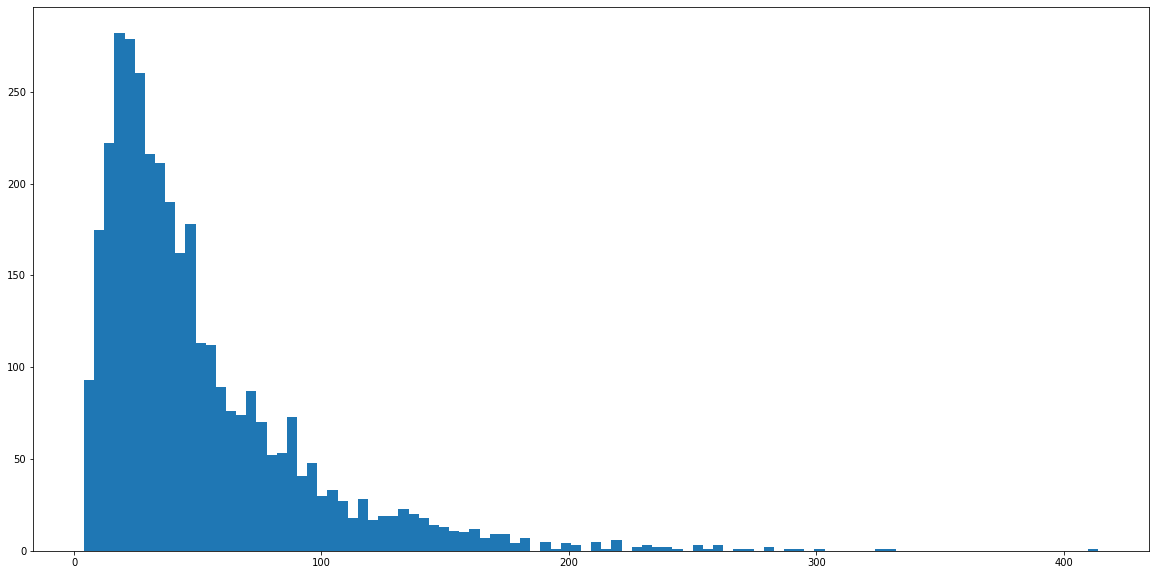

In [ ]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_es_df to hold text sentences and corresponding sentiment values

sentiment_es_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_es_df['text_raw'] = sentiment_es_df['text_raw'].astype('string')
sentiment_es_df['text_raw'] = sentiment_es_df['text_raw'].str.strip()

sentiment_es_df.head()
sentiment_es_df.info()

,text_raw
0,Vine a Comala porque me dijeron que acá vivía ...
1,Mi madre me lo dijo.
2,Y yo le prometí que vendría a verlo en cuanto ...
3,Le apreté sus manos en señal de que lo haría; ...
4,«No dejes de ir a visitarlo —me recomendó—.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3556 entries, 0 to 3555
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  3556 non-null   string
dtypes: string(1)
memory usage: 27.9 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_es_df['text_clean'] = sentiment_es_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_es_df['text_clean'] = sentiment_es_df['text_clean'].astype('string')
sentiment_es_df['text_raw_len'] = sentiment_es_df['text_raw'].apply(lambda x: len(x))

sentiment_es_df.head()
sentiment_es_df.info()

,text_raw,text_clean,text_raw_len
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76
1,Mi madre me lo dijo.,mi madre me lo dijo.,20
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3556 entries, 0 to 3555
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      3556 non-null   string
 1   text_clean    3556 non-null   string
 2   text_raw_len  3556 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 83.5 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_es_df = sentiment_es_df[sentiment_es_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_es_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_es_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_es_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(3556, 3)

In [ ]:
sentiment_es_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
1946,¡Tú!,!tu!,4
1244,—No.,--no.,4
1301,—No.,--no.,4
954,—Sí.,--si.,4
3310,—Yo.,--yo.,4
1593,—oí.,--oi.,4
1643,—Sí.,--si.,4
1749,Así.,asi.,4
705,—Sí.,--si.,4
1166,—No.,--no.,4


# **English Translation** (Pick ONE Option)

OPTIONAL: ~30m for Pedro Páramo by Juan Rulfo

## OPTION (a): Upload English Translation

## OPTION (B): Create English Translation

In [ ]:
from textblob import TextBlob

In [ ]:
novel_sentences_ls[:10]

['Vine a Comala porque me dijeron que acá vivía mi padre, un tal Pedro Páramo.',
 'Mi madre me lo dijo.',
 'Y yo le prometí que vendría a verlo en cuanto ella muriera.',
 'Le apreté sus manos en señal de que lo haría; pues ella estaba por morirse y yo en plan de prometerlo todo.',
 '«No dejes de ir a visitarlo —me recomendó—.',
 'Se llama de otro modo y de este otro.',
 'Estoy segura de que le dará gusto conocerte».',
 'Entonces no pude hacer otra cosa sino decirle que así lo haría, y de tanto decírselo se lo seguí diciendo aun después que a mis manos les costó trabajo zafarse de sus manos muertas.',
 'Todavía antes me había dicho: \n—No vayas a pedirle nada.',
 'Exígele lo nuestro.']

In [ ]:
%%time

# NOTE:

# Create an English translation

novel_sentences_en_ls = []

for asentence_es_str in tqdm(novel_sentences_ls):
  t_es = TextBlob(asentence_es_str)
  t_en = t_es.translate(from_lang="es", to="en")
  # print(f'ESPANOL: {asentence_es_str}')
  # print(f'ENGLISH: {t_en}')
  # print(t_en.sentiment)
  novel_sentences_en_ls.append(t_en)

novel_sentences_en_ls[:10]

In [ ]:
line_no = list(range(len(text_es_raw)))
print(line_no)

In [ ]:
sentiment_en_df = pd.DataFrame('text_es_raw':novel_sentences_es_ls,'text_raw':novel_sentences_en_ls)



# **Sentiment Analysis**

## **OPTION (a): Upload Sentiment Datafile**

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

Saving novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv to novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv
User uploaded file "novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv" with length 1057947 bytes
CPU times: user 175 ms, sys: 15.9 ms, total: 191 ms
Wall time: 16.7 s


In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Do Androids Dream of Electric Sheep by Philip K. Dick" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Do Androids Dream Of Electric Sheep By Philip K Dick'

In [ ]:
sentiment_df = pd.read_csv(novel_filename_str, index_col=[0])
sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,roberta
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523,-0.990126
1,ONE\r\n\r\n\r\nA merry little surge of electri...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652,0.998224
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610,0.996304
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788,-0.998246
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301,-0.999424


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5664 entries, 0 to 5663
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text_raw      5664 non-null   object 
 1   text_clean    5664 non-null   object 
 2   text_raw_len  5664 non-null   int64  
 3   vader         5664 non-null   float64
 4   textblob      5664 non-null   float64
 5   distilbert    5664 non-null   float64
 6   roberta       5664 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 354.0+ KB


## **OPTION (b): Calculate Sentiments and Save**

### **From Native Spanish**

#### **sentiment-analysis-spanish**

In [ ]:
!pip install sentiment-analysis-spanish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.0 MB 520 kB/s 


In [ ]:
from sentiment_analysis_spanish import sentiment_analysis

sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [ ]:
# Test

print(sentiment.sentiment("me gusta la tombola es genial"))

0.9304396176531412


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76
1,Mi madre me lo dijo.,mi madre me lo dijo.,20
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43


In [ ]:
%%time

# NOTE: 

sentiment_df['sas'] = sentiment_df['text_clean'].apply(lambda x : sentiment.sentiment(x))
sentiment_df.head(10)

CPU times: user 1.55 s, sys: 880 µs, total: 1.55 s
Wall time: 1.62 s


,text_raw,text_clean,text_raw_len,sas
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76,1.152384e-07
1,Mi madre me lo dijo.,mi madre me lo dijo.,20,6.966061e-04
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59,5.847123e-03
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107,6.258479e-05
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43,5.682078e-02
5,Se llama de otro modo y de este otro.,se llama de otro modo y de este otro.,37,3.020513e-02
6,Estoy segura de que le dará gusto conocerte».,"estoy segura de que le dara gusto conocerte"".",45,1.931173e-02
7,Entonces no pude hacer otra cosa sino decirle ...,entonces no pude hacer otra cosa sino decirle ...,181,1.037208e-09
8,Todavía antes me había dicho: —No vayas a ped...,todavia antes me habia dicho: --no vayas a ped...,56,1.391739e-06
9,Exígele lo nuestro.,exigele lo nuestro.,19,2.702816e-01


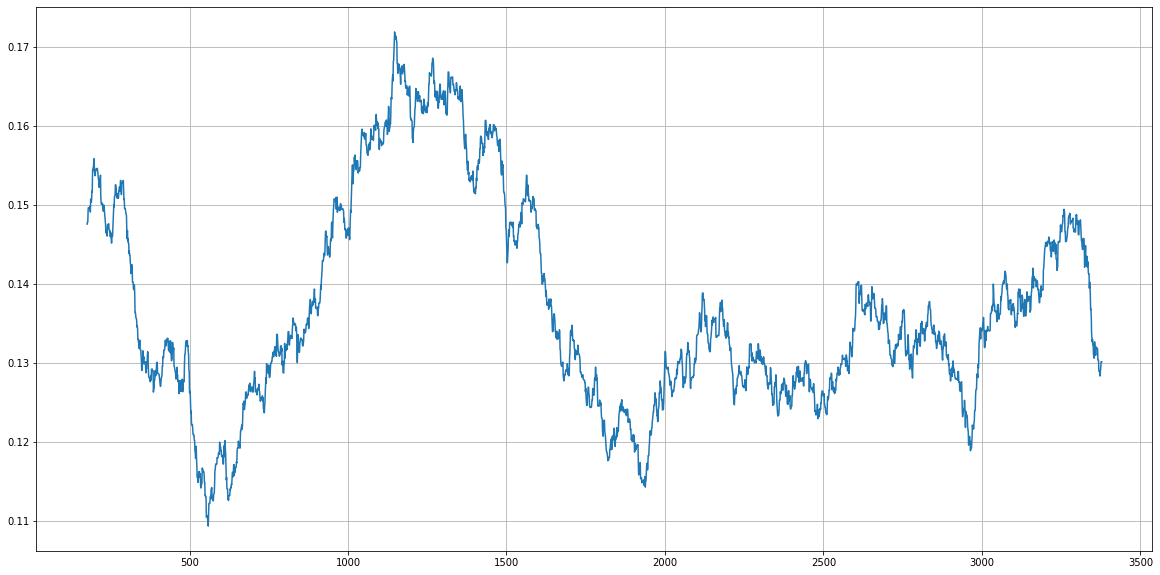

In [ ]:
_ = sentiment_df['sas'].rolling(int(0.1*sentiment_df.shape[0]), center=True).mean().plot(grid=True)

#### **PySentimiento**

In [ ]:
!pip install pysentimiento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 44.3 MB/s 
     |████████████████████████████████| 132 kB 57.5 MB/s 
     |████████████████████████████████| 212 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 77.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/e3be95c8efad7f480ce8aab2221188ecb78e40f3/config.json
Model config RobertaConfig {
  "_name_or_path": "pysentimiento/robertuito-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_

Downloading:   0%|          | 0.00/435M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/e3be95c8efad7f480ce8aab2221188ecb78e40f3/pytorch_model.bin
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/858k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/e3be95c8efad7f480ce8aab2221188ecb78e40f3/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/e3be95c8efad7f480ce8aab2221188ecb78e40f3/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--pysentimiento--robertuito-sentiment-analysis/snapshots/e3be95c8efad7f480ce8aab2221188ecb78e40f3/tokenizer_config.json
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Test

analyzer.predict("Qué gran jugador es Messi")

AnalyzerOutput(output=POS, probas={POS: 0.994, NEG: 0.003, NEU: 0.003})

In [ ]:
analyzer.predict("Qué gran jugador es Messi").output

'POS'

In [ ]:
%%time

# NOTE: 

line_pol_raw_ls = analyzer.predict(sentiment_df['text_raw'].to_list())

  0%|          | 0/112 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 3556
  Batch size = 32
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.


CPU times: user 12.5 s, sys: 204 ms, total: 12.7 s
Wall time: 13.6 s


In [ ]:
# Translate NEG/NEU/POS into -1/0/1 

def str2int(astr):
  if astr=='POS':
    return 1
  elif astr=='NEG':
    return -1
  else:
    return 0

line_pol_ls = [str2int(x.output) for x in line_pol_raw_ls]
line_pol_ls[:10]


[-1, 0, -1, 0, 0, 0, 1, -1, -1, 0]

In [ ]:
sentiment_df['pysentimiento'] = line_pol_ls
sentiment_df.head()

,text_raw,text_clean,text_raw_len,sas,pysentimiento
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76,1.152384e-07,-1
1,Mi madre me lo dijo.,mi madre me lo dijo.,20,6.966061e-04,0
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59,5.847123e-03,-1
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107,6.258479e-05,0
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43,5.682078e-02,0


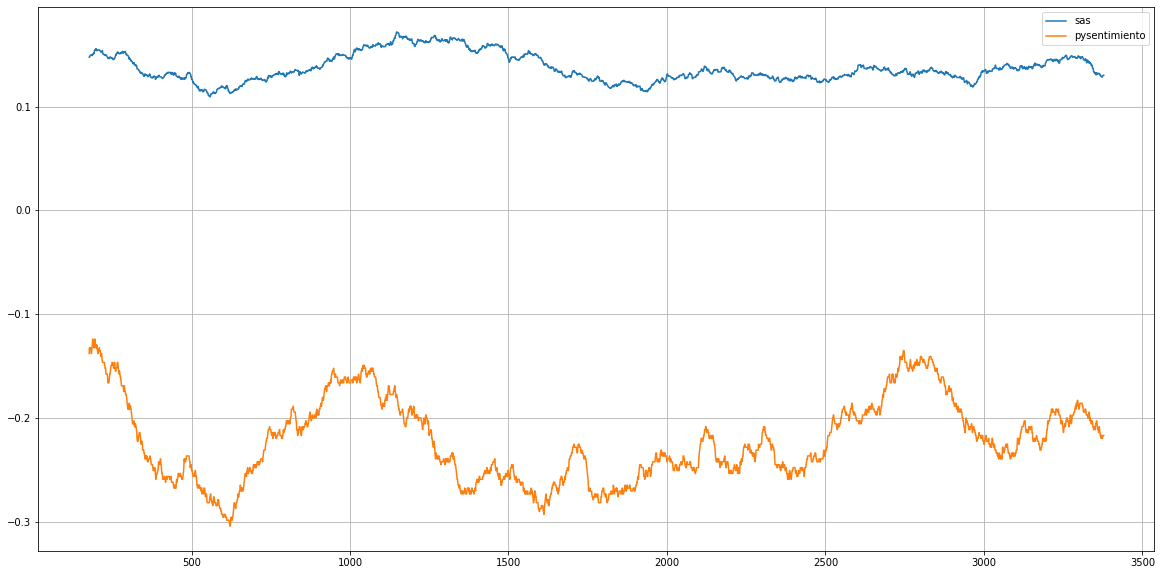

In [ ]:
_ = sentiment_df[['sas','pysentimiento']].rolling(int(0.1*sentiment_df.shape[0]), center=True).mean().plot(grid=True)

#### **MultiBERT (NLPTown)**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_multibert_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  sentiment_ls = predictions.predictions.argmax(-1)
  label_ls = pd.Series(sentiment_ls).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Create DataFrame with texts, predictions, labels, and scores
  # line_no_ls = list(range(len(sentiment_ls)))
  # distilbert_df = pd.DataFrame(list(zip(line_no_ls, text_clean_ls,sentiment_ls,label_ls,score_ls)), columns=['line_no','line','sentiment','label','score'])
  # distilbert_df.head()

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
# Test

line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.', 'This']
sentiment_signed_ls, label_ls = get_multibert_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

***** Running Prediction *****
  Num examples = 5
  Batch size = 8


sentiment_signed_ls:
  [-0.45410796999931335, -0.4175810217857361, -0.8332948684692383, -0.44408541917800903, -0.3755945861339569]
label_ls:
  0    4 stars
1    3 stars
2    5 stars
3    4 stars
4    5 stars
dtype: object


In [ ]:
label_ls[0]

'4 stars'

In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_multibert_sentiment(text_clean_ls)

***** Running Prediction *****
  Num examples = 3556
  Batch size = 8


CPU times: user 18.7 s, sys: 102 ms, total: 18.8 s
Wall time: 26.3 s


In [ ]:
line_pol_ls = [int(x[0]) for x in label_ls] 
line_pol_ls[:10]

[5, 5, 1, 1, 5, 1, 4, 1, 1, 5]

In [ ]:
sentiment_df['multibert'] = line_pol_ls
sentiment_df.head()

,text_raw,text_clean,text_raw_len,sas,pysentimiento,multibert
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76,1.152384e-07,-1,5
1,Mi madre me lo dijo.,mi madre me lo dijo.,20,6.966061e-04,0,5
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59,5.847123e-03,-1,1
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107,6.258479e-05,0,1
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43,5.682078e-02,0,5


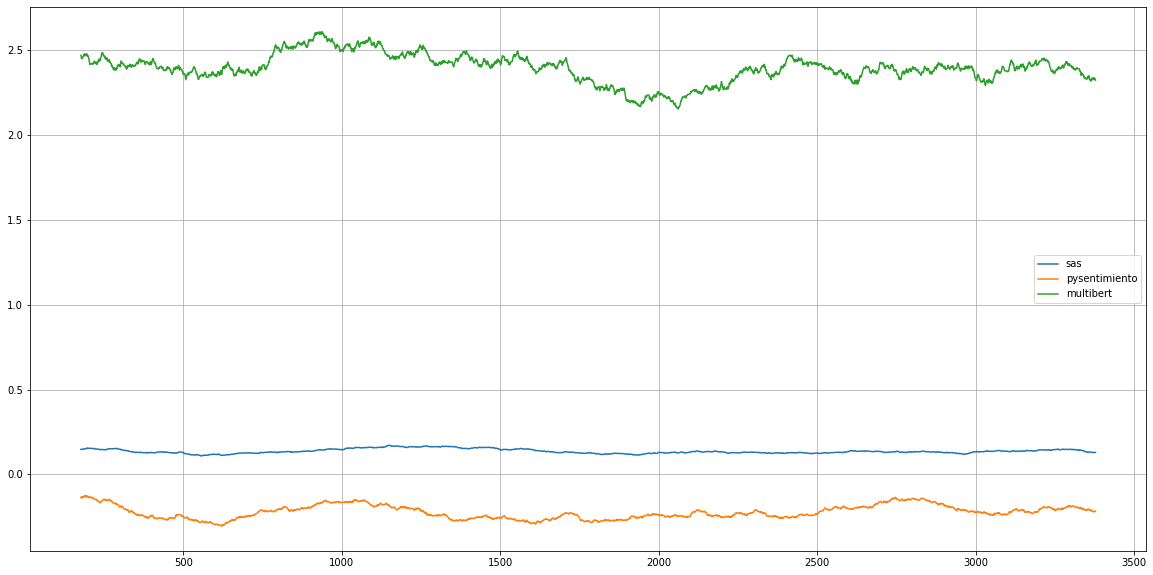

In [ ]:
_ = sentiment_df[['sas','pysentimiento','multibert']].rolling(int(0.1*sentiment_df.shape[0]), center=True).mean().plot(grid=True)

#### **RoBERTa Es Large**

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 11.7 MB/s 


In [ ]:
import sentencepiece

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer, XLMRobertaForCausalLM

model_name = "mrm8488/t5-base-finetuned-span-sentiment-extraction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-span-sentiment-extraction/snapshots/04a3fe1f7373c1f33b82e9fb06d2b2635e0fc5a0/config.json
Model config T5Config {
  "_name_or_path": "mrm8488/t5-base-finetuned-span-sentiment-extraction",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 

ValueError: ignored

In [ ]:
def get_sentiment_span(text):
  input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1
  
  generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()
  
  predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    
  return predicted_span

In [ ]:
# Test

get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'


TypeError: ignored

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer

model_name = "llange/xlm-roberta-large-spanish"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/439 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

loading file sentencepiece.bpe.model from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/sentencepiece.bpe.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/tokenizer_config.json


Downloading:   0%|          | 0.00/750 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "llange/xlm-roberta-large-spanish",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--llange--xlm-roberta-large-spanish/snapshots/87965ab2356326c1db48f670ee449f05424d1c9f/pytorch_model.bin
All model checkpoint weights were used when initializing XLMRobertaForMaskedLM.

All the weights of XLMRobertaForMaskedLM were initialized from the model checkpoint at llange/xlm-roberta-large-spanish.
If your task is similar to the task the model of the checkpoint was trained on, you can already use XLMRobertaForMaskedLM for predictions without further training.
No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_robertaeslg_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  sentiment_ls = predictions.predictions.argmax(-1)
  label_ls = pd.Series(sentiment_ls).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Create DataFrame with texts, predictions, labels, and scores
  # line_no_ls = list(range(len(sentiment_ls)))
  # distilbert_df = pd.DataFrame(list(zip(line_no_ls, text_clean_ls,sentiment_ls,label_ls,score_ls)), columns=['line_no','line','sentiment','label','score'])
  # distilbert_df.head()

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [ ]:
# Test

line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.', 'This']
sentiment_signed_ls, label_ls = get_robertaeslg_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
***** Running Prediction *****
  Num examples = 5
  Batch size = 8


ValueError: ignored

In [ ]:
label_ls[0]

'4 stars'

In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_multibert_sentiment(text_clean_ls)

***** Running Prediction *****
  Num examples = 3556
  Batch size = 8


CPU times: user 18.7 s, sys: 102 ms, total: 18.8 s
Wall time: 26.3 s


In [ ]:
line_pol_ls = [int(x[0]) for x in label_ls] 
line_pol_ls[:10]

[5, 5, 1, 1, 5, 1, 4, 1, 1, 5]

In [ ]:
sentiment_df['multibert'] = line_pol_ls
sentiment_df.head()

,text_raw,text_clean,text_raw_len,sas,pysentimiento,multibert
0,Vine a Comala porque me dijeron que acá vivía ...,vine a comala porque me dijeron que aca vivia ...,76,1.152384e-07,-1,5
1,Mi madre me lo dijo.,mi madre me lo dijo.,20,6.966061e-04,0,5
2,Y yo le prometí que vendría a verlo en cuanto ...,y yo le prometi que vendria a verlo en cuanto ...,59,5.847123e-03,-1,1
3,Le apreté sus manos en señal de que lo haría; ...,le aprete sus manos en senal de que lo haria; ...,107,6.258479e-05,0,1
4,«No dejes de ir a visitarlo —me recomendó—.,no dejes de ir a visitarlo --me recomendo--.,43,5.682078e-02,0,5


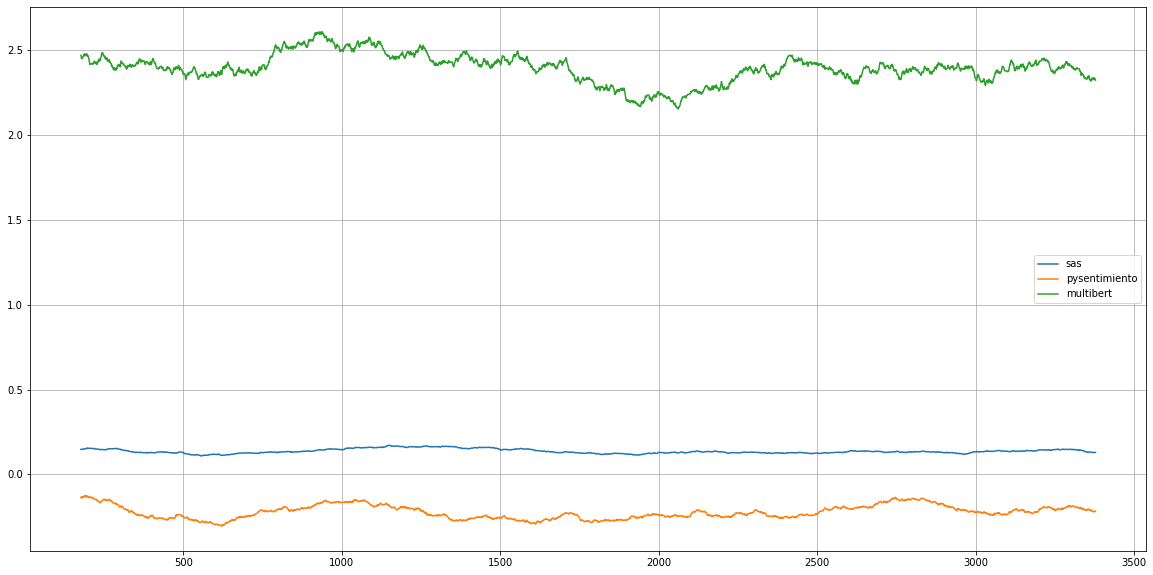

In [ ]:
_ = sentiment_df[['sas','pysentimiento','multibert']].rolling(int(0.1*sentiment_df.shape[0]), center=True).mean().plot(grid=True)

In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_distilbert_sentiment(text_clean_ls)

sentiment_df['distilbert'] = sentiment_ls
sentiment_df.head()
sentiment_df.info()

***** Running Prediction *****
  Num examples = 5664
  Batch size = 8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text_raw      5664 non-null   string 
 1   text_clean    5664 non-null   string 
 2   text_raw_len  5664 non-null   int64  
 3   vader         5664 non-null   float64
 4   textblob      5664 non-null   float64
 5   distilbert    5664 non-null   float64
dtypes: float64(3), int64(1), string(2)
memory usage: 265.6 KB
CPU times: user 14.9 s, sys: 82.3 ms, total: 15 s
Wall time: 14.8 s


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523
1,ONE A merry little surge of electricity p...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301


In [ ]:
filename_sentiment = f"novel_sentiment_{slugify(''.join(novel_filename_str.split('.')[:-1]).lower(), separator='_')}.csv"
sentiment_df.to_csv(filename_sentiment)

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_sentiment}] <<<<<')



     >>>>> SAVED PLOT TO FILE: [novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv] <<<<<


In [ ]:
files.download(filename_sentiment)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **From English Translation**

#### **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 11.8 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500
1,ONE A merry little surge of electricity p...,one a merry little surge of electricity piped ...,127,0.2732
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404
5,"""I'll reset it and you'll be awake and - "" ...","""i will reset it and you will be awake and - ""...",79,0.4939
6,Her voice held bitter sharpness.,her voice held bitter sharpness.,32,-0.4215
7,"""I don't want to be awake.""","""i do not want to be awake.""",27,-0.0572
8,"He seated himself beside her, bent over her, a...","he seated himself beside her, bent over her, a...",66,0.0000
9,"""If you set the surge up high enough, you'll b...","if you set the surge up high enough, you will ...",90,0.4588


#### **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000
1,ONE A merry little surge of electricity p...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750
5,"""I'll reset it and you'll be awake and - "" ...","""i will reset it and you will be awake and - ""...",79,0.4939,0.0000
6,Her voice held bitter sharpness.,her voice held bitter sharpness.,32,-0.4215,-0.1000
7,"""I don't want to be awake.""","""i do not want to be awake.""",27,-0.0572,0.0000
8,"He seated himself beside her, bent over her, a...","he seated himself beside her, bent over her, a...",66,0.0000,0.1000
9,"""If you set the surge up high enough, you'll b...","if you set the surge up high enough, you will ...",90,0.4588,0.2150


#### **DistilBERT**

* https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

In [ ]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_distilbert_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  sentiment_ls = predictions.predictions.argmax(-1)
  label_ls = pd.Series(sentiment_ls).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Create DataFrame with texts, predictions, labels, and scores
  # line_no_ls = list(range(len(sentiment_ls)))
  # distilbert_df = pd.DataFrame(list(zip(line_no_ls, text_clean_ls,sentiment_ls,label_ls,score_ls)), columns=['line_no','line','sentiment','label','score'])
  # distilbert_df.head()

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs


In [ ]:
# Test

line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.', 'This']
sentiment_signed_ls, label_ls = get_distilbert_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

***** Running Prediction *****
  Num examples = 5
  Batch size = 8


sentiment_signed_ls:
  [0.9998562, -0.9997524619102478, 0.9998695, 0.95023483, 0.99314415]
label_ls:
  0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
dtype: object


In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_distilbert_sentiment(text_clean_ls)

sentiment_df['distilbert'] = sentiment_ls
sentiment_df.head()
sentiment_df.info()

***** Running Prediction *****
  Num examples = 5664
  Batch size = 8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text_raw      5664 non-null   string 
 1   text_clean    5664 non-null   string 
 2   text_raw_len  5664 non-null   int64  
 3   vader         5664 non-null   float64
 4   textblob      5664 non-null   float64
 5   distilbert    5664 non-null   float64
dtypes: float64(3), int64(1), string(2)
memory usage: 265.6 KB
CPU times: user 14.9 s, sys: 82.3 ms, total: 15 s
Wall time: 14.8 s


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523
1,ONE A merry little surge of electricity p...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301


In [ ]:
filename_sentiment = f"novel_sentiment_{slugify(''.join(novel_filename_str.split('.')[:-1]).lower(), separator='_')}.csv"
sentiment_df.to_csv(filename_sentiment)

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_sentiment}] <<<<<')



     >>>>> SAVED PLOT TO FILE: [novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv] <<<<<


In [ ]:
files.download(filename_sentiment)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Fine-Tuned Sentiment RoBERTa**

* https://huggingface.co/siebert/sentiment-roberta-large-english (RoBERTa Large)

In [ ]:
# Import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "pysentimiento/robertuito-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/858k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/925 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/435M [00:00<?, ?B/s]

In [ ]:
%%time

# Test: text_sentiment_dt['cdickins_achristmascarol']['text_clean']

# NOTE:  1m38s 14:00EST on 01 Nov 2022 Colab Pro (The Great Gatsby)
#        1m39s 17:05EST on 01 Nov 2022 Colab Pro (The Great Gatsby)

# Compute sentiment time series

def get_sp_robertuito_sentiment(text_clean_ls, sample_size=10):
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()
  # text_clean_ls = text_sentiment_dt['cdickins_achristmascarol']['text_clean'].to_list()

  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(text_clean_ls,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)

  # Transform predictions to labels
  preds = predictions.predictions.argmax(-1)
  label_ls = pd.Series(preds).map(model.config.id2label)
  score_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

  # Adjust for POS/NEG sign
  label_score_ls = list(zip(label_ls,score_ls))
  sentiment_signed_ls = [ascore if alabel.lower().strip()=='positive' else (-1.0*ascore) for alabel, ascore in label_score_ls] 

  # Create DataFrame with texts, predictions, labels, and scores
  df = pd.DataFrame(list(zip(text_clean_ls,preds,label_ls,score_ls)), columns=['text','pred','label','score'])
  # df.head()

  # print(f'label_ls:\n  {label_ls[:sample_size]}')
  # print(f'score_ls:\n {score_ls[:sample_size]}')

  return sentiment_signed_ls, label_ls

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


In [ ]:
# Test

line_ls = ['A mi me gusto mucho','El es feo and malo.','Que bueno!','No importa.']
sentiment_signed_ls, label_ls = get_sp_robertuito_sentiment(line_ls)

print(f'sentiment_signed_ls:\n  {sentiment_signed_ls}')
print(f'label_ls:\n  {label_ls}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
***** Running Prediction *****
  Num examples = 4
  Batch size = 8


sentiment_signed_ls:
  [-0.985173225402832, -0.9960547089576721, -0.9508892893791199, -0.8419109582901001]
label_ls:
  0    POS
1    NEG
2    POS
3    NEU
dtype: object


In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len
0,El ingenioso hidalgo don Quijote de la Mancha ...,el ingenioso hidalgo don quijote de la mancha ...,680
1,"Y, para que dello conste, di la presente en Va...","y, para que dello conste, di la presente en va...",126
2,Juan Gallo de Andrada.,juan gallo de andrada.,22
3,TESTIMONIO DE LAS ERRATAS Este libro no tiene...,testimonio de las erratas este libro no tiene ...,140
4,En el Colegio de la Madre de Dios de los Teólo...,en el colegio de la madre de dios de los teolo...,116


In [ ]:
%%time

# NOTE: ~20m

text_clean_ls = sentiment_df['text_clean'].to_list()
sentiment_ls, label_ls = get_sp_robertuito_sentiment(text_clean_ls)

sentiment_df['robertuito_sp'] = sentiment_ls
sentiment_df.head()
sentiment_df.info()

NameError: ignored

In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,roberta
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523,-0.990126
1,ONE A merry little surge of electricity p...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652,0.998224
2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610,0.996304
3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788,-0.998246
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301,-0.999424


In [ ]:
filename_sentiment = f"novel_sentiment_{slugify(''.join(novel_filename_str.split('.')[:-1]).lower(), separator='_')}.csv"
sentiment_df.to_csv(filename_sentiment)

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_sentiment}] <<<<<')



     >>>>> SAVED PLOT TO FILE: [novel_sentiment_pkdick_doandroidsdreamofelectricsheep.csv] <<<<<


In [ ]:
files.download(filename_sentiment)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Plot Sentiment**

In [ ]:
sentiment_df.insert(0, 'SeqNo', list(range(0, sentiment_df.shape[0])))

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,roberta
0,0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523,-0.990126
1,1,ONE\r\n\r\n\r\nA merry little surge of electri...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652,0.998224
2,2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610,0.996304
3,3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788,-0.998246
4,4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301,-0.999424


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib
print(matplotlib.__version__)

3.2.2


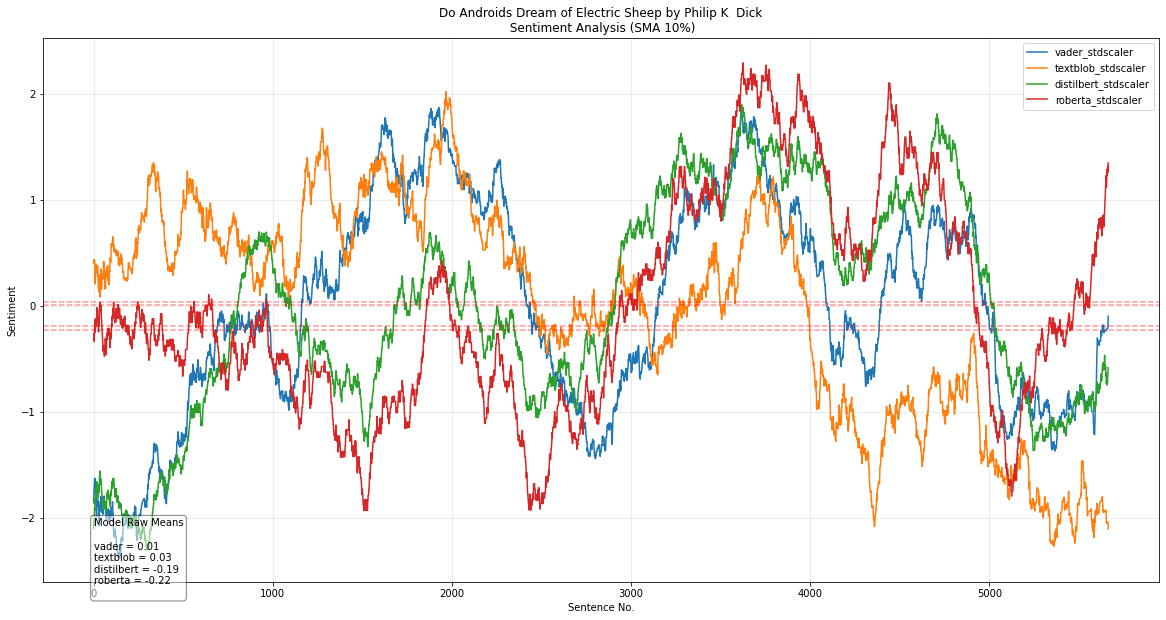

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

_ = plt.rcParams['figure.figsize'] = [20, 10]

# Dict of sentiment model means
sentiment_mean_dt = {}

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_mean_dt['vader'] = sentiment_df['vader'].mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_mean_dt['textblob'] = sentiment_df['textblob'].mean()

distilbert_col = f'distilbert_sma{window_percent}'
sentiment_df[distilbert_col] = sentiment_df['distilbert'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_mean_dt['distilbert'] = sentiment_df['distilbert'].mean()

roberta_col = f'roberta_sma{window_percent}'
sentiment_df[roberta_col] = sentiment_df['roberta'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_mean_dt['roberta'] = sentiment_df['roberta'].mean()

# Normalize Time Series to same y-range
sentiment_model_ls = [vader_col, textblob_col, distilbert_col, roberta_col]
sentiment_model_norm_ls = ['vader_stdscaler',
                           'textblob_stdscaler',
                           'distilbert_stdscaler',
                           'roberta_stdscaler']

sentiment_df[sentiment_model_norm_ls] = StandardScaler().fit_transform(sentiment_df[sentiment_model_ls])

sentiment_df.plot(y=sentiment_model_norm_ls, x='SeqNo')

_ = plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.grid(True, alpha=0.3)
_ = plt.legend(loc='best')

model_mean_str = 'Model Raw Means\n\n'
for amodel, amean in sentiment_mean_dt.items():
  model_mean_str += f'{amodel} = {amean:.2f}\n'
  _ = plt.axhline(y = amean, label='book', color='red', linestyle='--', alpha=0.4)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
_ = plt.text(0.05, -2.0, model_mean_str, 
             # transform=plt.transAxes, 
             fontsize=10,
             verticalalignment='top', 
             bbox=props)

_ = plt.show();

# print(sentiment_mean_ls)

In [ ]:
sentiment_df.head()

,SeqNo,text_raw,text_clean,text_raw_len,vader,textblob,distilbert,roberta,vader_sma10,textblob_sma10,distilbert_sma10,roberta_sma10,vader_stdscaler,textblob_stdscaler,distilbert_stdscaler,roberta_stdscaler
0,0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do androids dream of electric sheep?,36,0.2500,0.0000,-0.978523,-0.990126,-0.038505,0.040116,-0.365773,-0.246568,-1.853426,0.402143,-2.091887,-0.322476
1,1,ONE\r\n\r\n\r\nA merry little surge of electri...,one a merry little surge of electricity piped ...,127,0.2732,-0.1875,0.962652,0.998224,-0.036407,0.040575,-0.361001,-0.242186,-1.764442,0.434826,-2.034502,-0.259539
2,2,Surprised - it always surprised him to find hi...,surprised - it always surprised him to find hi...,155,0.4215,0.1500,0.946610,0.996304,-0.036222,0.040462,-0.363219,-0.244824,-1.756584,0.426769,-2.061169,-0.297420
3,3,"Now, in her bed, his wife Iran opened her gray...","now, in her bed, his wife iran opened her gray...",108,0.0000,0.0000,-0.910788,-0.998246,-0.034690,0.040321,-0.358471,-0.247423,-1.691619,0.416694,-2.004082,-0.334757
4,4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he said to her.,47,-0.4404,-0.3750,-0.999301,-0.999424,-0.034569,0.040180,-0.354349,-0.243218,-1.686494,0.406689,-1.954512,-0.274355


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "RoBERTa" #@param ["VADER", "TextBlob", "DistilBERT", "RoBERTa"]

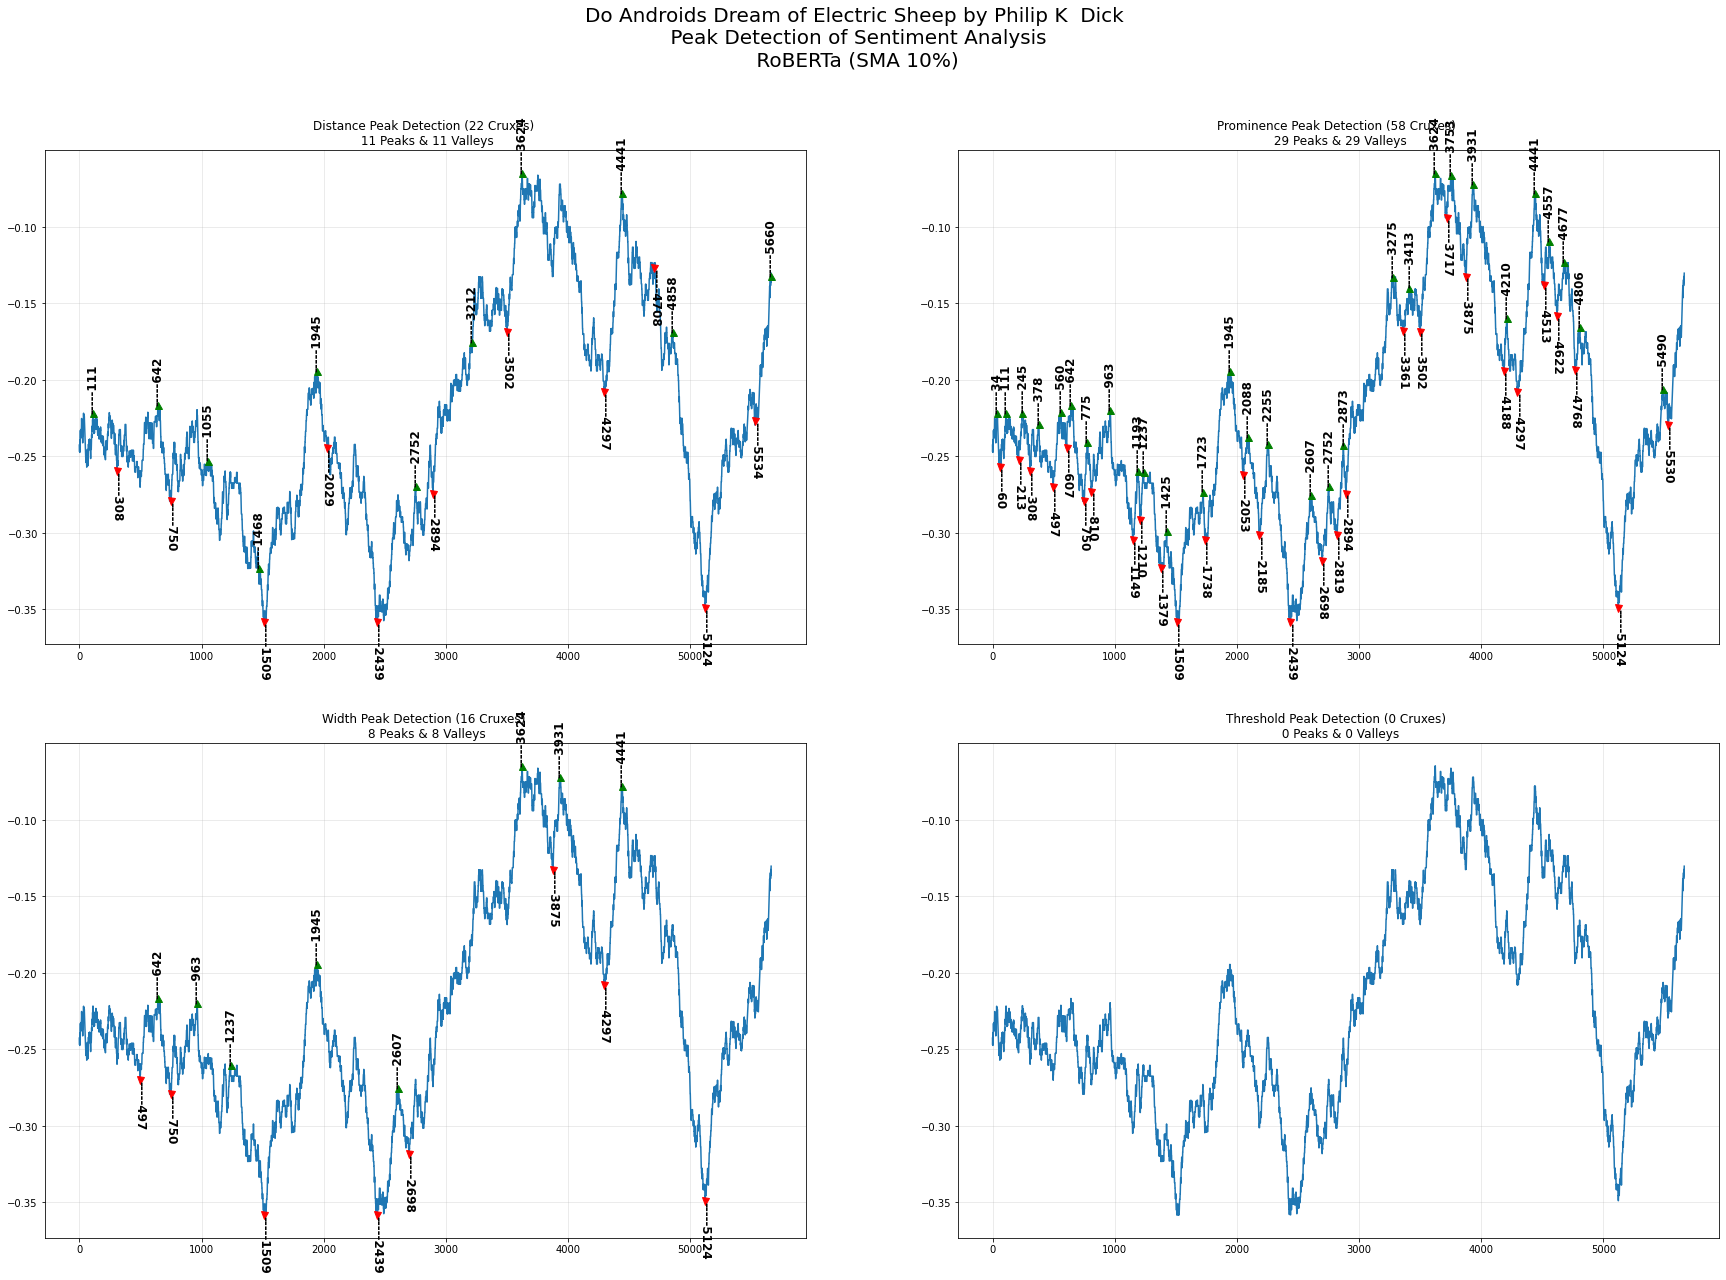

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 410 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.033 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 60 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.005 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis\n {Sentiment_Model} (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

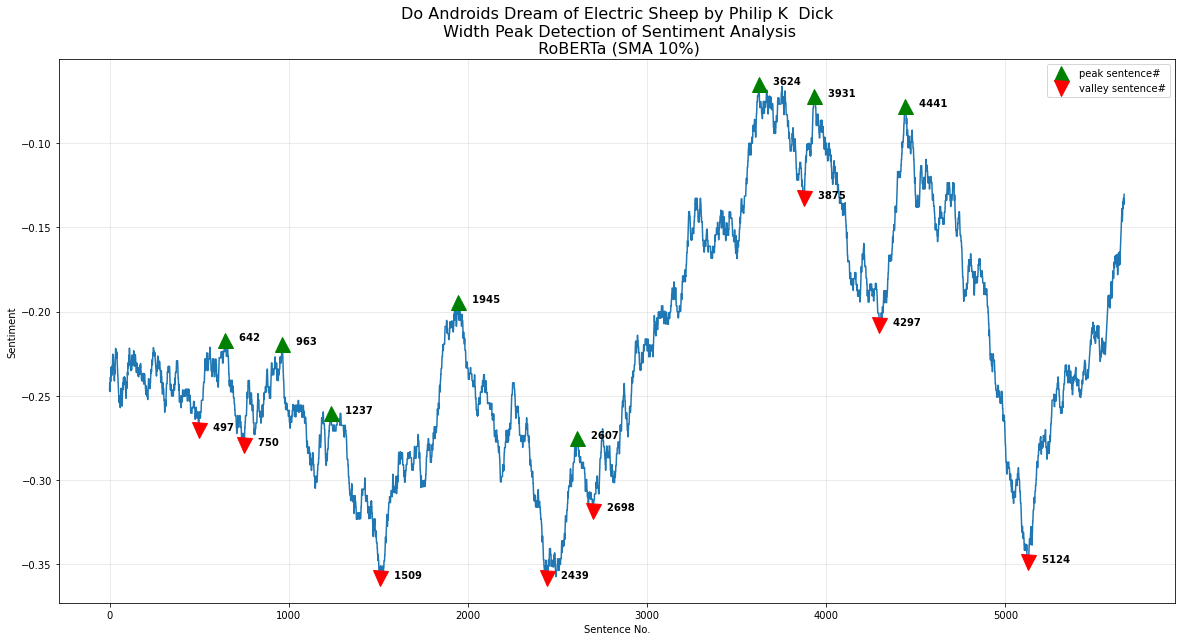



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_Do_Androids_Dream_of_Electric_Sheep_by_Philip_K__Dick.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Width" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis\n {Sentiment_Model} (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #642:

"Max Polokov," Bryant said.
"That's what it calls itself, anyhow.
Assuming Dave was right.
Everything is based on that assumption, this entire list.
And yet the Voigt-Kampff Altered Scale has only been administered to the first three, the two Dave retired and then Polokov.
It was while Dave was administering the test; that's when Polokov lasered him."
"Which proves that Dave was right," Rick said.
Otherwise he would not have been lasered; Polokov would have no motive.
"You get started for Seattle," Bryant said.
"DON'T TELL THEM FIRST; I'LL HANDLE IT.
Listen."
He rose to his feet, soberly confronted Rick.
"When you run the Voigt-Kampff scale up there, if one of the humans fails to pass it - "

"That can't happen," Rick said.
"One day, a few weeks ago, I talked with Dave about exactly that.
He had been thinking along the same lines.
I had a memo from the Soviet police, W.P.O.
itself, cir

19574

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #642:

"Max Polokov," Bryant said.
"That's what it calls itself, anyhow.
Assuming Dave was right.
Everything is based on that assumption, this entire list.
And yet the Voigt-Kampff Altered Scale has only been administered to the first three, the two Dave retired and then Polokov.
It was while Dave was administering the test; that's when Polokov lasered him."
"Which proves that Dave was right," Rick said.
Otherwise he would not have been lasered; Polokov would have no motive.
"You get started for Seattle," Bryant said.
"DON'T TELL THEM FIRST; I'LL HANDLE IT.
Listen."
He rose to his feet, soberly confronted Rick.
"When you run the Voigt-Kampff scale up there, if one of the humans fails to pass it - "

"That can't happen," Rick said.
"One day, a few weeks ago, I talked with Dave about exactly that.
He had been thinki

# **END OF NOTEBOOK**